In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Libraries**

In [2]:
# Import needed packages
import sys, os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, History, EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import load_model

Using TensorFlow backend.


In [0]:
#!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 306kB/s 
     |████████████████████████████████| 491kB 45.1MB/s 
     |████████████████████████████████| 3.2MB 32.8MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0rc3
    Uninstalling tensorflow-1.15.0rc3:
      Successfully uninstalled tensorflow-1.15.0rc3


In [0]:
import tensorflow
tensorflow.__version__

'1.14.0'

## Load data


In [0]:
base_dir = '/content/drive/My Drive/Coding Contest 2019/ML/Facial expression recognition'
database_emotion = pd.read_csv(base_dir + '/FER+FERG.csv')

## Explore the data

In [0]:
database_emotion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90864 entries, 0 to 90863
Data columns (total 2 columns):
emotion    90864 non-null int64
pixels     90864 non-null object
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [0]:
database_emotion.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


## Prepare the data

In [0]:
data_file = base_dir + '/FER+FERG.csv'
width, height = 48, 48
n_samples = 90864

def prepare_data(data_file):
    X = []
    Y = []
    first = True
    for line in open(data_file):
        if first:
            first = False
        else:
            row = line.split(',')
            X.append([int(img_pixel) for img_pixel in row[1].split()])
            Y.append(int(row[0]))
           
    X = np.array(X)/255.0  # Scaling
    X = X.reshape(n_samples, width, width, 1)  # Reshape
    Y = np.array(Y) 
    return X, Y

X, Y = prepare_data(data_file)
print(X.shape)
print(Y.shape)
num_labels=print(len(set(Y)))

(90864, 48, 48, 1)
(90864,)
7


In [0]:
# Save into numy arrays
np.save('/content/drive/My Drive/Coding Contest 2019/ML/Facial expression recognition/X_data', X)
np.save('/content/drive/My Drive/Coding Contest 2019/ML/Facial expression recognition/Y_labels', Y)

In [0]:
# Load npy arrays
X = np.load('/content/drive/My Drive/Coding Contest 2019/ML/Facial expression recognition/X_data.npy')
Y = np.load('/content/drive/My Drive/Coding Contest 2019/ML/Facial expression recognition/Y_labels.npy')

In [5]:
# Check the number of classes in each category
def class_number(Y): 
    num_labels=set(Y)
    count_class={}
    for i in range(len(num_labels)):
        count_class[i]=sum([1 for y in Y if y==i])
    return count_class

balance=class_number(Y)
print(balance)

{0: 14122, 1: 9118, 2: 12540, 3: 16319, 4: 13704, 5: 11924, 6: 13137}


## Split data into training and testing set

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# Arrange the labels into the classes
y_train= (np.arange(7) == y_train[:,None]).astype(np.float32)
y_test=(np.arange(7) == y_test[:,None]).astype(np.float32)

In [0]:
labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Build the model architecture

In [0]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 50
width, height = 48, 48

model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)      

## Compile the model

In [0]:
# Compile the model with adam optimizer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

## Define callbacks


In [14]:
history = History()

filepath="/content/drive/My Drive/Coding Contest 2019/ML/Facial expression recognition/facial_expression_model_train.h5"
checkpoint = ModelCheckpoint(filepath, monitor = "val_acc", verbose = 1, save_best_only = True, mode = 'max')
earlystopping = EarlyStopping(monitor = 'val_acc', mode = 'max', min_delta=1, patience = 200, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=10, epsilon=0.007)
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_images=True)
callbacks = [history,checkpoint]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


## Train the model

In [15]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 72691 samples, validate on 18173 samples
Epoch 1/50
72691/72691 [==============================] - 155s 2ms/step - loss: 1.9799 - acc: 0.1770 - val_loss: 1.9049 - val_acc: 0.1998

Epoch 00001: val_acc improved from -inf to 0.19980, saving model to /content/drive/My Drive/Coding Contest 2019/ML/Facial expression recognition/facial_expression_model_train.h5
Epoch 2/50
72691/72691 [==============================] - 147s 2ms/step - loss: 1.9077 - acc: 0.1927 - val_loss: 1.9048 - val_acc: 0.2000

Epoch 00002: val_acc improved from 0.19980 to 0.20002, saving model to /content/drive/My Drive/Coding Contest 2019/ML/Facial expression recognition/facial_expression_model_train.h5
Epoch 3/50
72691/72691 [==============================] - 146s 2ms/step - loss: 1.6497 - acc: 0.2979 - val_loss: 3.0296 - val_acc: 0.2643

Epoch 00003: val_acc improved from 0.20002 to 0.26435, saving model to /conten

## Save the model

In [0]:
model.save('facial_expression_model_train.h5')

## Plot the training and validation loss and accuracy

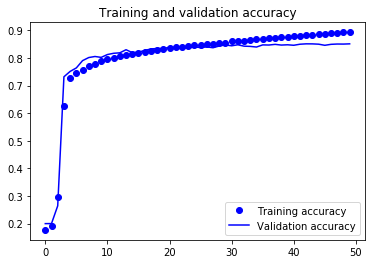

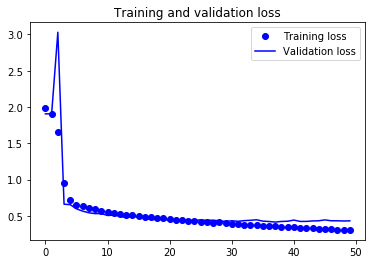

In [17]:
accuracy = history.history['acc']
valid_acc = history.history['val_acc']
loss = history.history['loss']
valid_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, valid_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, valid_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()